In [1]:
import os
import glob
import nibabel as nib
import numpy as np
import pandas as pd
import random
from random import randrange

from nilearn.image import concat_imgs,new_img_like, index_img, math_img, mean_img
import nilearn.input_data as nid
from nltools.data import Brain_Data
from nltools.data import Design_Matrix
from nilearn.plotting import plot_glass_brain
from nilearn import plotting
from nilearn.masking import apply_mask
from nltools.stats import regress as regression
import nilearn
from utils import *
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
base_dir = '/Users/yiyuwang/Dropbox/Projects/NTFA_method/'
mask_dir = base_dir + 'masks/'
figures_dir = base_dir + 'figures/'
rest_data_dir = base_dir + 'rest_data/'
res_dir = base_dir + 'results/sub2/'
mask_img_8mm = nib.load(mask_dir + 'MNI152_wholebrain_mask_8mm.nii.gz')
nifti_masker = NiftiMasker(mask_img = mask_img_8mm)
subjects = [1,2]


total_tp = 320

# Create Design Matrix

In [3]:
columns_list = ['Experimental Condition','Baseline']
dm = np.zeros((total_tp,len(columns_list)))

# experimental
exp_index = list(range(2,8))
# baseline
bl_index = [0,1]

dm = pd.DataFrame(dm, columns = columns_list)
for v_indx in exp_index:
    start = v_indx * 40
    end = start + 40
    events_index = np.arange(start, end, 40)
    units = [ f + u for f in events_index for u in range(20)]
    dm.iloc[units,0] = 1

for v_indx in bl_index:
    start = v_indx * 40
    end = start + 40
    events_index = np.arange(start, end, 40)
    units = [ f + u for f in events_index for u in range(20)]
    dm.iloc[units,1] = 1

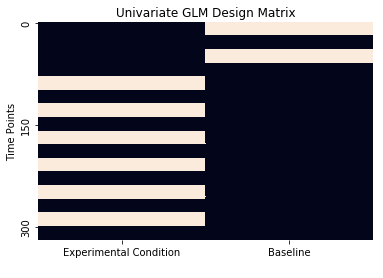

In [4]:
ax = sns.heatmap(dm,yticklabels=150, cbar=False)
ax.set(xlabel=' ', ylabel='Time Points', title = 'Univariate GLM Design Matrix')
ax.set_yticklabels(labels=ax.get_yticklabels(), va='center')
plt.show()

In [5]:
# add intercept to dm for analysis:
dm['intercept'] = np.ones(total_tp)

# Univariate Analysis


In [6]:

columns_list = ['Exp','Baseline']
con=pd.DataFrame(data = {'EvB': [1,-1]})

for scenario in [1,2,3]:
    data_dir = base_dir + f'ntfa_degeneracy_simulated_data/Scenario_{scenario}_subjects_2_1/nifti_files/'
    for s in subjects:

        #load subject data:
        sub_files = sorted(glob.glob(data_dir + 'participant_' + str(s) + '*.nii'))
        for index in np.arange(1,len(sub_files)*2+1,2):
            sub_files.insert(index,rest_data_dir + f'rest_{randrange(1,10)}.nii')
        sub_img = concat_imgs(sub_files) 

        # run regression
        b, _, p, _, res = regression(dm, nifti_masker.fit_transform(sub_img), mode='ols')

        # save betas:
        betas_img = nifti_masker.inverse_transform(b)

        for c in range(len(columns_list)):
            b_img = index_img(betas_img, c)
            nii_file_path = res_dir + f'scenario{scenario}_univariate_sub{s}_{columns_list[c]}.nii.gz'
            nib.save(b_img, nii_file_path)

        # run Experiment vs Baseline contrast:
        contrast_betas = np.dot(b[0:len(con),:].T,con['EvB'])
        contrast_betas_img = nifti_masker.inverse_transform(contrast_betas)
        nib.save(contrast_betas_img, res_dir + f'scenario{scenario}_univariate_sub{s}_contrast.nii.gz')


# Take group average

In [7]:
for scenario in [1,2,3]:
    sub1 = nib.load(res_dir + f'scenario{scenario}_univariate_sub1_contrast.nii.gz')
    sub2 = nib.load(res_dir + f'scenario{scenario}_univariate_sub2_contrast.nii.gz')
    avg_img = math_img('(img1 + img2)/2', img1 = sub1, img2=sub2)
    nib.save(avg_img, res_dir + f'scenario{scenario}_sub2_univariate_mean_contrast.nii.gz')

# Plot

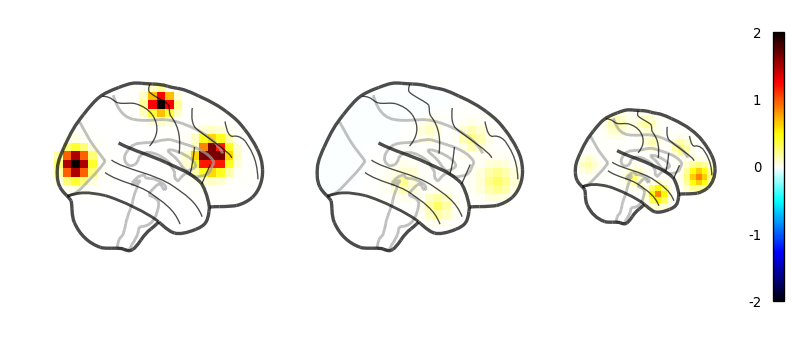

In [9]:
vmax = 2
column_width = 3.3
plt.rc('figure', figsize=(column_width,
                         0.66 * column_width),
                dpi=120)
plt.rc('savefig', dpi=150)
plt.rc('font', size=8)
fig, axes = plt.subplots(1, 3,
                        figsize=(2.4*column_width, 1*column_width))
img_slice = nib.load(res_dir + 'scenario1_sub2_univariate_mean_contrast.nii.gz')

plot = plot_glass_brain(
    img_slice, plot_abs=False, colorbar=False, symmetric_cbar=True, display_mode='x', vmax = vmax,
    figure=fig, axes=axes[0]
)


img_slice = nib.load(res_dir + 'scenario2_sub2_univariate_mean_contrast.nii.gz')
plot = plot_glass_brain(
    img_slice, plot_abs=False, colorbar=False, symmetric_cbar=True, display_mode='x',vmax = vmax,
    figure=fig, axes=axes[1]
)

img_slice = nib.load(res_dir + 'scenario3_sub2_univariate_mean_contrast.nii.gz')
plot = plot_glass_brain(
    img_slice, plot_abs=False, colorbar=True, symmetric_cbar=True, display_mode='x',vmax = vmax,
    figure=fig, axes=axes[2]
)


plt.show()
fig.savefig(figures_dir +'/all_scenario_sub2_contrast.png',dpi=150)